In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import os
import sys
from typing import Tuple

from dataclasses import dataclass

if '' in sys.path:
    sys.path.remove('')

module_path = os.path.abspath(os.path.join('../python'))
if module_path not in sys.path:
    sys.path.append(module_path)

# print(sys.path)

import networkx as nx

from graphPlot import drawGraph, SIZE
from const import *

plt.rcParams['figure.figsize'] = SIZE
# print(plt.rcParams['figure.figsize'])

## Data Augmentation

Let's do a hello-world experiment on MNIST dataset, here is a simple augmentation:

In [3]:

import aug2conv
from mxnet.ndarray import NDArray
from mxnet.gluon.data import DataLoader
from mxnet.gluon.nn import Sequential

data = aug2conv.getData()

imgs: NDArray
imgs, ls = next(data.__iter__())

(10, 10)


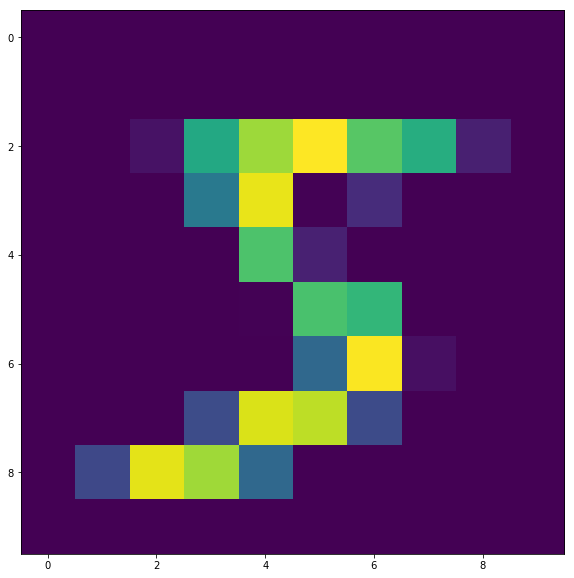

In [4]:
img1 = imgs[0].squeeze(axis=(0,))
print(img1.shape)
plt.imshow(img1.asnumpy())

## Data Augmentation

Now I can shift vertically

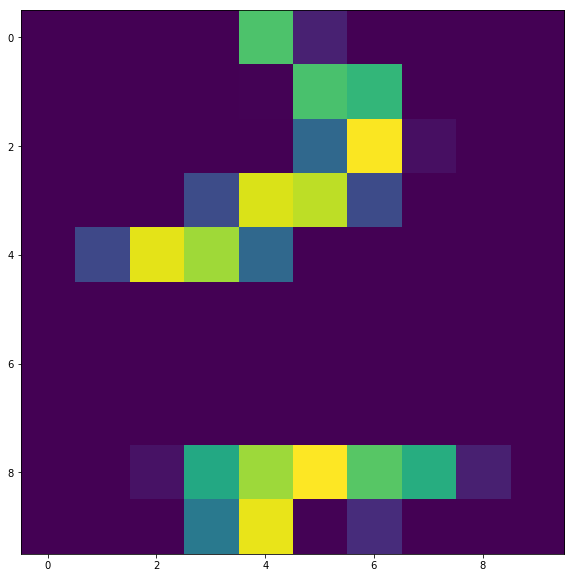

In [5]:
auged = img1.copy()
auged = aug2conv.shiftY(auged, 6)
plt.imshow(auged.asnumpy())

## Data Augmentation

... and horizontally

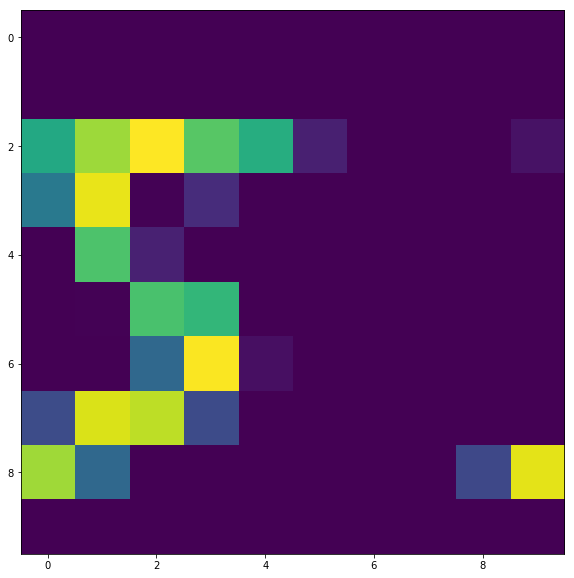

In [6]:
auged = img1.copy()
auged = aug2conv.shiftX(auged, 7)
plt.imshow(auged.asnumpy())

## Data Augmentation

I can do it all day until it covers every possibilities

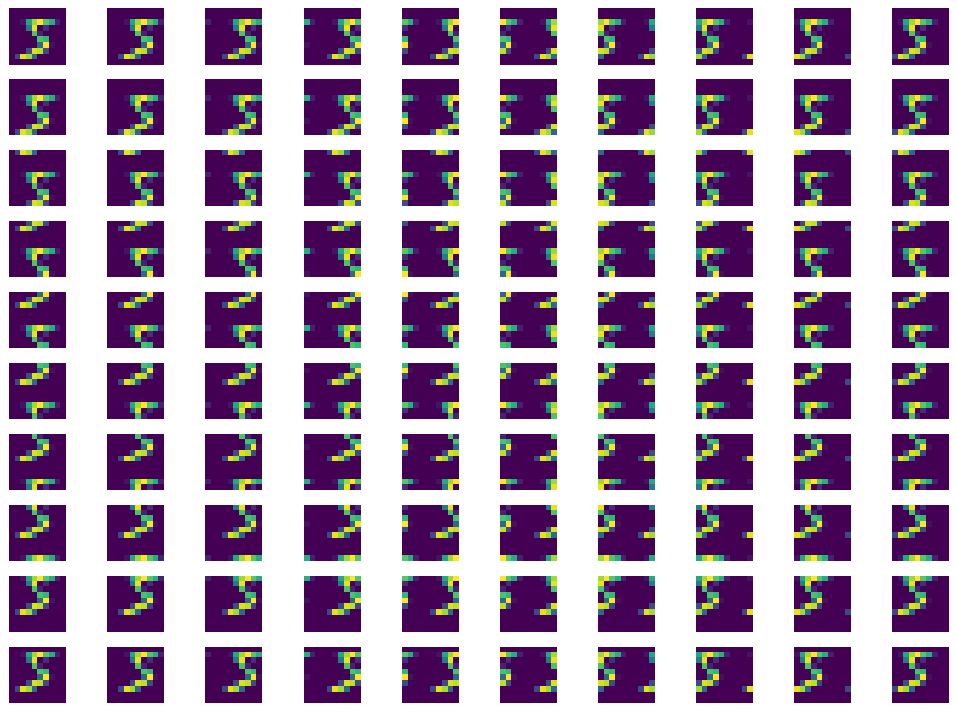

In [7]:
import utils.helper

augmenter = aug2conv.Augmenter(img1)
auggedUp = augmenter.aug1(img1)
utils.helper.viewWeights(auggedUp)

## Data Augmentation - Start Learning!

### **2 layers only**

1. Highway only bypassing Linear/FC/~~Dense/Perceptron~~
    
    - Designed to break symmetry at saddle points*

    - WITHOUT initialisation (all weights start with 0)
    
    - 10x10 => 10x10 => ReLU

2. Plain old Linear/FC

    - 10x10 => one-hot 1~10 => ReLU
   
---

[*] Y. Li and Y. Yuan, “Convergence Analysis of Two-layer Neural Networks with ReLU Activation” NIPS 2017, pp. 1–11.

## Data Augmentation - Start Learning!

<img src="assets/skip1Net.png" width="400">

---

[*] Y. Li and Y. Yuan, “Convergence Analysis of Two-layer Neural Networks with ReLU Activation” NIPS 2017, pp. 1–11.

In [8]:

from mxnet import autograd, initializer
import mxnet.gluon as glu
from pathlib import Path

lossFn = glu.loss.SoftmaxCrossEntropyLoss()

In [9]:

@dataclass
class HWY(glu.HybridBlock):

    def __init__(self, layers: Tuple):
        super(HWY, self).__init__()
        self.delegate = glu.nn.HybridSequential()
        self.delegate.add(*layers)

    def getLayers(self):
        return list(self.delegate)

    def hybrid_forward(self, F, x, *args, **kwargs):
        r = self.delegate.forward(x, *args)
        return r + x.reshape(r.shape)

    def __hash__(self):
        return hash(self.delegate)

In [10]:
# Build a feed-forward network
# this goofy-looking skip architecture is from:
# [1] Y. Li and Y. Yuan, “Convergence Analysis of Two-layer Neural Networks with ReLU Activation,” no. Nips, pp. 1–11, 2017.
# designed to break symmetry

def newModel() -> glu.nn.HybridSequential:
    model = glu.nn.HybridSequential()
    # with model.name_scope():
    model.add(
        HWY((
            glu.nn.Dense(100),
        )),
        glu.nn.Activation('relu'),
        # Skip((
        #     glu.nn.Dense(100),
        # )),
        # glu.nn.Activation('relu'),
        glu.nn.Dense(10)
    )

    # init = initializer.Uniform()
    init = initializer.Zero()
    model.initialize(ctx=CTX, init=init)
    return model

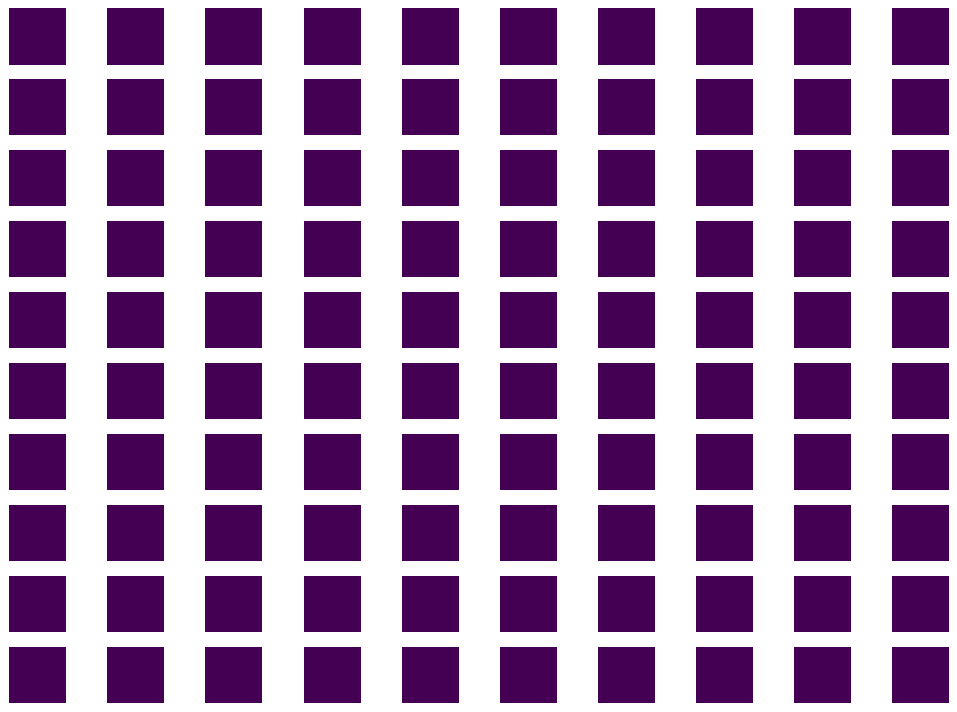

In [11]:

# Remember all weights start with 0
model = newModel()
model.forward(imgs.as_in_context(CTX))

fc1 = model[0].getLayers()[0]
utils.helper.viewFCWeights(fc1)

## Data Augmentation - On Raw Dataset

In [12]:
def train(
        name: str,
        loader: DataLoader = data,
        lossTarget=0.15,
        maxEpochs=100,
        aug=lambda v: v
) -> Sequential:
    model = newModel()

    filePath = f"{os.getcwd()}/{MODEL_CHKPNT}/{name}.model"

    try:
        model.load_parameters(filePath)
        print(f">> model loaded from: {filePath}")
    except Exception as ee:
        print(f">> model being learned from scratch: {filePath}")

        optimizer = glu.Trainer(model.collect_params(), 'sgd', {'learning_rate': 0.01})

        # cc = 0
        for epoch in range(maxEpochs):
            sumLoss = 0
            for imgs, labels in loader:
                # print(f"loading batch {cc} - of {imgs.shape[0]}")
                # cc += 1
                imgs = imgs.squeeze(axis=(1,))

                imgs, labels = aug((imgs, labels))
                imgs = imgs.as_in_context(CTX)
                labels = labels.as_in_context(CTX)

                with autograd.record():
                    output = model.forward(imgs)
                    loss = lossFn(output, labels)

                loss.backward()
                sumLoss += loss.mean().asscalar()

                optimizer.step(imgs.shape[0] / 2)

            else:
                print(f"Training loss: {sumLoss / len(loader)}")

            if sumLoss / len(loader) <= lossTarget:
                break

        os.makedirs(Path(filePath).parent, exist_ok=True)
        model.save_parameters(filePath)
        print(f">>> model saved to: {filePath}")

    return model

>> model loaded from: /home/peng/git/convnet-abstraction/slide/.model_checkpoints/raw.model


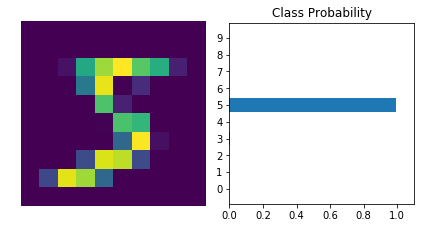

In [13]:

model = train("raw")

logits = model.forward(auggedUp.as_in_context(CTX))
ps = mx.ndarray.softmax(logits, axis=1)

utils.helper.view_classify(auggedUp[0], ps[0])

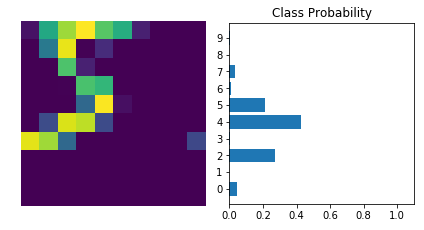

In [19]:
utils.helper.view_classify(auggedUp[88], ps[88])

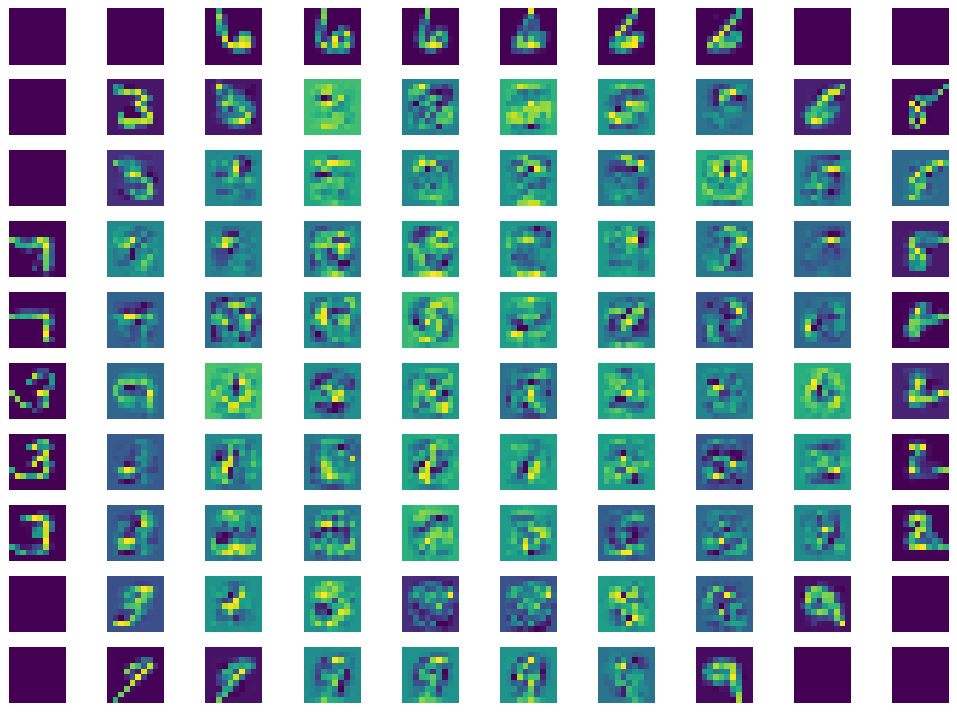

In [14]:

fc1 = model[0].getLayers()[0]
utils.helper.viewFCWeights(fc1)

## Data Augmentation - On *Augmented* Dataset

In [15]:

# now let's enable augmentation

augModel = train("aug", aug=augmenter.augFirstTuple)

>> model loaded from: /home/peng/git/convnet-abstraction/slide/.model_checkpoints/aug.model


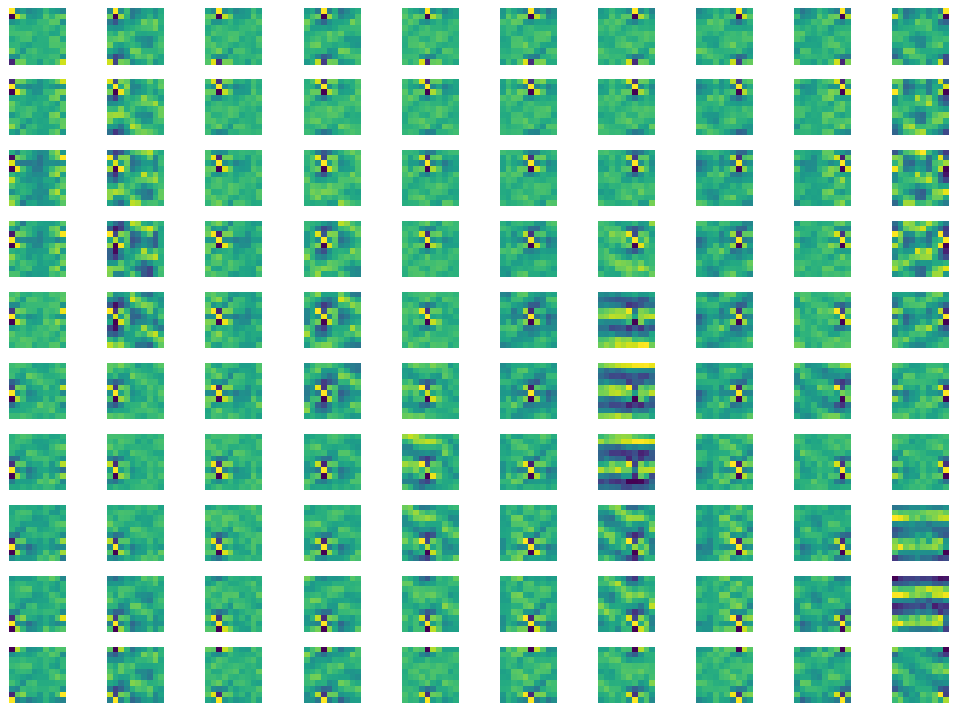

In [16]:

fc1 = augModel[0].getLayers()[0]
utils.helper.viewFCWeights(fc1)

## Data Augmentation

- How did this happen? (you probably want to try this on neural-ODE)

<img src="assets/jon-batiste-reaction.gif">